In [2]:
% matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch, torch.utils.data, torchvision
import PIL
import os.path
import time
# import skimage, skimage.io
import time
import copy
from my_utils import *

In [3]:
MEAN = [0.485, 0.456, 0.406] # expected by pretrained resnet18
STD = [0.229, 0.224, 0.225] # expected by pretrained resnet18

# Full model

In [4]:
# load the data and add a column for occurrences
df = pandas.read_csv('./data/train_no_duplicates.csv')
grouped = df.groupby('Id',group_keys=False)
df['occurrences'] =  grouped.Id.transform('count')

I am creating a validation set which contains the new_whales and some of the whales which occur more often. 
Note that the training set it chosen in such a way that it does not contain any new_whales.

In [5]:
# For all of the whales which occur at least 11 times but ar not 'new_whale', take one random sample
tmp = df[(df.occurrences >+ 11) & (df.Id != 'new_whale')].groupby('Id',group_keys=False).apply(lambda x: x.sample(1,random_state=1234))
# Get the numeric indices of these samples
val_indices = tmp.index
# Append the indices for all the 'new_whales'
val_indices = val_indices.append(df[df.Id == 'new_whale'].index)

In [6]:
# Double check that all the indices are unique
print len(val_indices.unique()) == len(val_indices)

True


In [7]:
# Define the training indices as all the other indices
train_indices = df.index
train_indices = train_indices.drop(val_indices)

In [8]:
# Have a look at what the validation set looks like
df.loc[val_indices]

,Unnamed: 0,Image,Id,Hash_val,Copies,occurrences
6041,2666,45880deb.jpg,w_0e737d0,c5de92c1edb21269,1,17
3138,9446,f5ac7c84.jpg,w_1287fbc,fdc0f66ba80f8246,2,29
8730,9001,ea561a0e.jpg,w_17ee910,ec399e96d216c625,1,15
7849,9235,f0b8e93c.jpg,w_18eee6e,ea1a87e192a7b1e4,1,17
2967,5330,8ae4e714.jpg,w_1eafe46,ad90e32dac2bc33a,1,23
5017,3976,685c3732.jpg,w_2d99a0c,fa85a06f1dc2e439,2,12
1731,7546,c38ce869.jpg,w_43be268,bfca9265291b2a93,1,21
8266,8804,e53d2b96.jpg,w_4b7b80b,a9b7c6c82d37d0c8,1,13
3697,4920,7fce2c3f.jpg,w_4e52a49,abd694691e82e17c,2,12
7068,1406,24ef92ce.jpg,w_540fd73,b48ac73468dba569,1,14


In [9]:
# Define DataSamplers for train and validation set
sampler = {'train': torch.utils.data.sampler.SubsetRandomSampler(train_indices.tolist()),\
           'val': torch.utils.data.sampler.SubsetRandomSampler(val_indices.tolist())}

In [10]:
# Define transformations for the train and validation set, 
# with data augmentation and without data augmentation, respectively.

transforms = {'train': torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=20.0), # Data augmentation
    torchvision.transforms.RandomGrayscale(), # Data augmentation
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), # Expected by pretrained neural network
    torchvision.transforms.Normalize(MEAN, STD) # Expected by pretrained neural network
    ]),\
            'val': torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), # Expected by pretrained neural network
    torchvision.transforms.Normalize(MEAN, STD) # Expected by pretrained neural network
    ])}

In [11]:
# In the WhaleDataset I used iloc, so now I need to reindex the dataframe
full_data = {x: WhaleDataset(df.reindex(columns=['Image','Id']),'./data/',transform=transforms[x]) for x in ['train', 'val']}

In [18]:
full_dataloader = {x: torch.utils.data.DataLoader(full_data[x],\
                                            batch_size=256,\
                                            shuffle=False,\
                                            num_workers=4,\
                                            sampler=sampler[x]) for x in ['train', 'val']}

In [19]:
print len(full_dataloader['val'].dataset.categories)

4246


In [20]:
# load the toy_model
toy_model = torch.load('./toy_model_all_layers_trained.pt')
print toy_model.fc

Linear(in_features=512, out_features=56, bias=True)


In [21]:
# Create the full model from the toy nodel by replacing the last layer
full_model = copy.deepcopy(toy_model)

# freeze layers
for params in full_model.parameters():
    params.requires_grad == False

# Create new final layer (unfrozen by default)
num_in = full_model.fc.in_features
num_out = len(full_dataloader['train'].dataset.categories)
full_model.fc = torch.nn.Linear(num_in,num_out)


# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model.to(device)

print full_model.fc

Linear(in_features=512, out_features=4246, bias=True)


In [22]:
# Choose the loss function (criterion) and optimizer.
# I make the same choice as for the toy_model.
criterion = torch.nn.CrossEntropyLoss()
full_optimizer = torch.optim.Adam(full_model.fc.parameters(),lr=0.001)

In [23]:
# train the full model
full_model, loss_vals, acc_vals = train_with_restart(
    full_model,full_dataloader,criterion,full_optimizer,device,\
    use_val=True,num_epochs=30,T_max=15)

Epoch 0 / 30
Training: Elapsed time: 55.0040 Loss: 9.1294 Acc: 0.0296
Validation: Elapsed time: 59.6240 Loss: 11.5013 Acc: 0.0489
Epoch 1 / 30
Training: Elapsed time: 116.8938 Loss: 6.8257 Acc: 0.0943
Validation: Elapsed time: 122.0000 Loss: 11.6003 Acc: 0.0548
Epoch 2 / 30
Training: Elapsed time: 179.0470 Loss: 5.7252 Acc: 0.1302
Validation: Elapsed time: 183.5279 Loss: 11.9494 Acc: 0.0533
Epoch 3 / 30
Training: Elapsed time: 238.0574 Loss: 4.9160 Acc: 0.2013
Validation: Elapsed time: 243.1519 Loss: 12.3015 Acc: 0.0578
Epoch 4 / 30
Training: Elapsed time: 298.0046 Loss: 4.2873 Acc: 0.3013
Validation: Elapsed time: 302.6269 Loss: 12.5863 Acc: 0.0533
Epoch 5 / 30
Training: Elapsed time: 357.9217 Loss: 3.7861 Acc: 0.4059
Validation: Elapsed time: 362.8119 Loss: 12.8400 Acc: 0.0548
Epoch 6 / 30
Training: Elapsed time: 417.7234 Loss: 3.3640 Acc: 0.5162
Validation: Elapsed time: 422.3577 Loss: 13.0388 Acc: 0.0533
Epoch 7 / 30
Training: Elapsed time: 477.2445 Loss: 3.0403 Acc: 0.6160
Validat

In [24]:
torch.save(full_model,'full_model_new_whale_as_extra_class_gpu.pt')

<IPython.core.display.Javascript object>


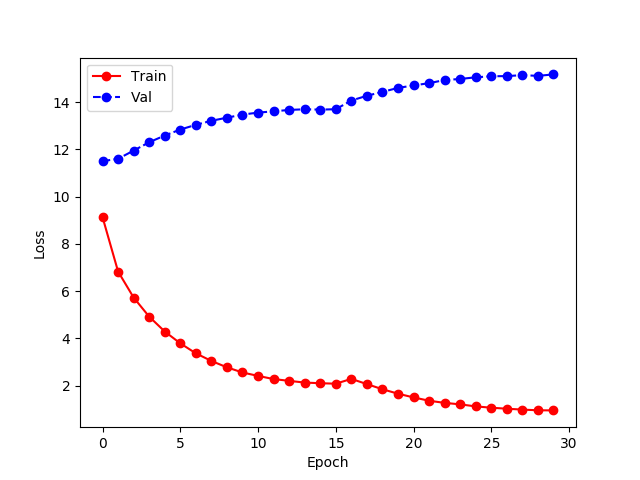

In [26]:
plt.figure()
plt.plot(range(30),loss_vals['train'],'-or',label='Train')
plt.plot(range(30),loss_vals['val'],'--ob',label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

<IPython.core.display.Javascript object>


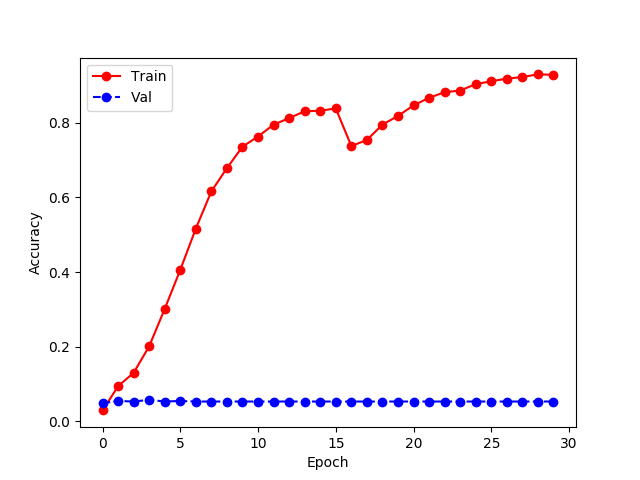

In [27]:
plt.figure()
plt.plot(range(30),acc_vals['train'],'-or',label='Train')
plt.plot(range(30),acc_vals['val'],'--ob',label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

Note that the validation set mainly contains new_whale, so it is not surprising that the validation accuracy saturates

In [35]:
print 'The best validation accuracy attainable whithout getting any of the new whales right is {:.6f}'.\
format((df.loc[val_indices].Id != 'new_whale').sum()/float(len(val_indices)))

The best validation accuracy attainable whithout getting any of the new whales right is 0.060741


At 0.053 the validation accuracy is close to that.

In [51]:
# Print the highest and lowest probability for predictions on the validation set.
prob = []
for image, label in full_dataloader['val']:
    image = image.to(device)
    
    out = torch.exp(full_model(image))
    norm = torch.norm(out,p=1,dim=1,keepdim=True)
    out = out/norm
    
    prob_tmp, _ = torch.topk(out,k=1,dim=1)
    prob_tmp = prob_tmp.tolist()
    
    # Note image is a tuple. The final batch may have a
    # different length. That is why I am using the length of image_names
    # in xrange below.
    for j in xrange(len(image)):
        prob.append(prob_tmp[j][0])

# print pandas.DataFrame({'Id' : pred_Id})
n = 20
print 'The {:d} highest probabilities are:'.format(n)
print pandas.DataFrame({'prob':prob}).nlargest(n,'prob')
print 'The {:d} lowest probabilities are:'.format(n)
print pandas.DataFrame({'prob':prob}).nsmallest(n,'prob')

The 20 highest probabilities are:
         prob
638  0.976232
85   0.963662
183  0.945190
394  0.923611
475  0.909232
99   0.902751
657  0.875980
115  0.863235
540  0.856760
598  0.826225
417  0.750958
127  0.748534
583  0.705786
208  0.696786
14   0.678898
507  0.659085
45   0.616516
207  0.606151
434  0.598498
179  0.594843
The 20 lowest probabilities are:
         prob
361  0.002823
634  0.003176
82   0.003614
581  0.003614
483  0.003636
440  0.003668
69   0.003671
321  0.003741
198  0.003889
296  0.003909
286  0.003995
231  0.004104
582  0.004277
2    0.004289
642  0.004300
44   0.004544
410  0.004577
613  0.004615
9    0.004619
599  0.004629


In [53]:
full_dataloader['train'].dataset.categories.index('new_whale')

0